mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/nagasai524/nyc-taxi-trip-records-from-jan-2023-to-jun-2023
License(s): U.S. Government Works
nyc-taxi-trip-records-from-jan-2023-to-jun-2023.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  nyc-taxi-trip-records-from-jan-2023-to-jun-2023.zip
replace data/nyc_yellow_taxi_trip_records_from_Jan_to_Aug_2023.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/nyc_yellow_taxi_trip_records_from_Jan_to_Aug_2023.csv  
   Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0           0         2  2023-06-30 23:59:59   2023-07-01 00:47:49   
1           1         2  2023-06-30 23:59:57   2023-07-01 00:17:36   
2           2         1  2023-06-30 23:59:55   2023-07-01 00:14:20   
3           3         2  2023-06-30 23:59:55   2023-07-01 00:05:52   


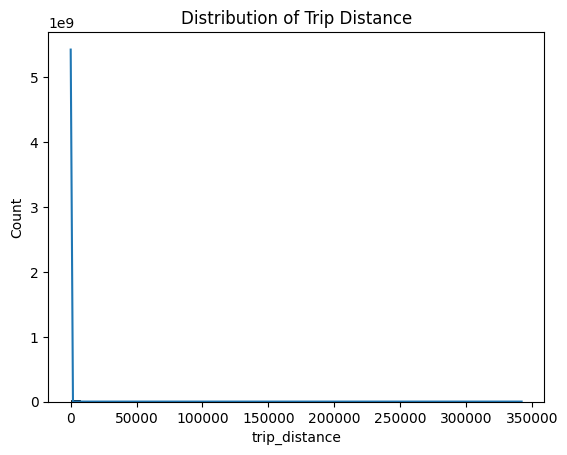

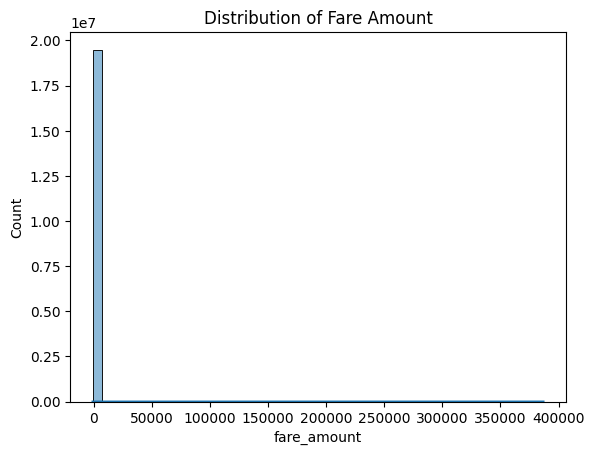

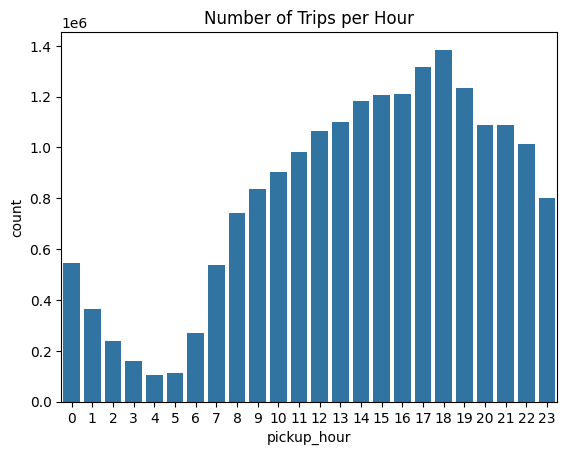

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nagasai524/nyc-taxi-trip-records-from-jan-2023-to-jun-2023
!unzip nyc-taxi-trip-records-from-jan-2023-to-jun-2023.zip -d data/


#Part 1: Tabular
import pandas as pd

# Load the dataset
file_path = "/content/data/nyc_yellow_taxi_trip_records_from_Jan_to_Aug_2023.csv"
df = pd.read_csv(file_path)

# Overview
print(df.head())
print(df.info())
print(df.describe())

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize trip distance
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title('Distribution of Trip Distance')
plt.show()

# Visualize fare amount
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.show()

# Convert pickup datetime to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Example: Extract hour for time-based analysis
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Example: Calculate trip duration
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60  # in minutes

sns.countplot(x='pickup_hour', data=df)
plt.title('Number of Trips per Hour')
plt.show()




Unnamed: 0                      0
VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count            528530
trip_distance                   0
RatecodeID                 528530
store_and_fwd_flag         528530
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
congestion_surcharge       528530
Airport_fee               3523475
airport_fee              16498114
pickup_hour                     0
trip_duration                   0
dtype: int64


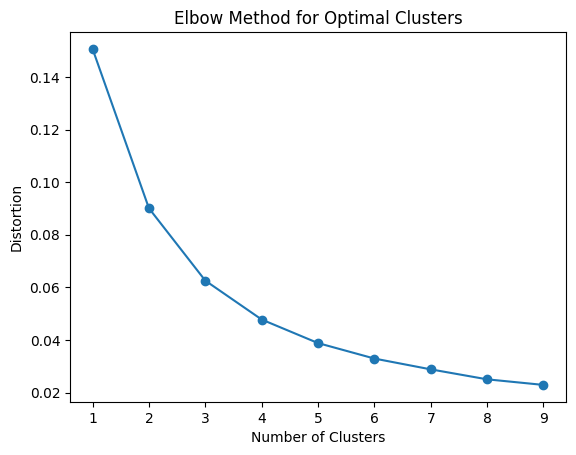

In [3]:
# Check for missing values
print(df.isnull().sum())

# Impute missing values
df['trip_distance'].fillna(df['trip_distance'].median(), inplace=True)
df['fare_amount'].fillna(df['fare_amount'].mean(), inplace=True)

# Remove outliers using IQR
Q1 = df['trip_distance'].quantile(0.25)
Q3 = df['trip_distance'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['trip_distance'] >= (Q1 - 1.5 * IQR)) & (df['trip_distance'] <= (Q3 + 1.5 * IQR))]

df = pd.get_dummies(df, columns=['payment_type'], drop_first=True)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_cols = ['trip_distance', 'fare_amount']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

# Determine optimal clusters using Elbow Method
features = df[['trip_distance', 'fare_amount']]
distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features)
    distortions.append(sum(np.min(cdist(features, kmeans.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

plt.plot(range(1, 10), distortions, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

# Apply KMeans with optimal clusters
optimal_clusters = 3  # Adjust based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

df['anomaly_score'] = np.min(cdist(features, kmeans.cluster_centers_, 'euclidean'), axis=1)
threshold = np.percentile(df['anomaly_score'], 99)
df['is_anomaly'] = df['anomaly_score'] > threshold

In [9]:
!pip install pycaret
from sklearn.model_selection import train_test_split

# Define target variable
target = 'fare_amount'

# Drop columns unnecessary for modeling
df_sampled = df.sample(frac=0.05, random_state=42)

# Redefine X and y
X = df_sampled.drop(columns=[target, 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'anomaly_score', 'is_anomaly', 'cluster'], errors='ignore')
y = df_sampled[target]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from pycaret.regression import *

# Set up PyCaret

#setup(data=tabular_df, target='Estimated Revenue (USD)', session_id=42)
exp = setup(data=pd.concat([X_train, y_train], axis=1),
            target=target,
            session_id=123,
            verbose=False,
            fold=2)
# Compare models and select the best
best_model = compare_models(exclude=['knn', 'en', 'par'])
# Create an ensemble model
ensemble_model = ensemble_model(best_model)

# Finalize the model
final_model = finalize_model(ensemble_model)

# Save the model
save_model(final_model, 'final_nyc_taxi_model')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,0.9990,0.0000,0.0001,0.7800
ridge,Ridge Regression,0.0000,0.0000,0.0000,0.9990,0.0000,0.0001,0.7000
br,Bayesian Ridge,0.0000,0.0000,0.0000,0.9990,0.0000,0.0001,0.8450
gbr,Gradient Boosting Regressor,0.0000,0.0000,0.0000,0.9880,0.0000,0.0005,25.9750
et,Extra Trees Regressor,0.0000,0.0000,0.0000,0.9873,0.0000,0.0001,16.4750
rf,Random Forest Regressor,0.0000,0.0000,0.0000,0.9866,0.0000,0.0002,25.9600
dt,Decision Tree Regressor,0.0000,0.0000,0.0000,0.9837,0.0000,0.0002,2.0100
lar,Least Angle Regression,0.0000,0.0000,0.0000,0.9567,0.0000,0.0010,0.7100
omp,Orthogonal Matching Pursuit,0.0000,0.0000,0.0000,0.9365,0.0000,0.0017,0.7050
lightgbm,Light Gradient Boosting Machine,0.0000,0.0000,0.0000,0.9082,0.0000,0.0004,50.4850


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0000,0.0000,0.0000,0.9989,0.0000,0.0001
1,0.0000,0.0000,0.0000,0.9990,0.0000,0.0001
Mean,0.0000,0.0000,0.0000,0.9990,0.0000,0.0001
Std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Unnamed: 0', 'VendorID',
                                              'passenger_count', 'trip_distance',
                                              'RatecodeID', 'PULocationID',
                                              'DOLocationID', 'extra', 'mta_tax',
                                              'tip_amount', 'tolls_amount',
                                              'improvement_surcharge',
                                              'total_amount',
                                              'congestion_surcharge',
                                              'Airport_fee', 'airport_fee',
                                              'pickup_hour', 'trip_...
                  TransformerWrapper(include=['store_and_fwd_flag'],
                                     transformer=OrdinalEncoder(cols=['store_and_fwd_flag'],
                     